In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import Data

In [6]:
df = pd.read_csv("jantungv6.csv", index_col="no_urut", sep=";")
df.drop(columns="oldpeak", inplace=True)

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal,target
no_urut,,,,,,,,,,,,,
1,34,0,0,1,161,0,1,145,1,1,3,3,1
2,71,0,1,3,180,1,3,102,1,1,1,3,0
3,29,0,1,3,236,0,1,140,0,1,1,1,1
4,57,1,1,2,231,1,1,114,0,2,2,2,0
5,59,1,0,1,200,0,2,129,1,1,1,3,1


# Binning

In [7]:
df.age = pd.cut(df.age, [0,5,12,18,40,200], labels=['balita', 'anak-anak', 'remaja', 'dewasa', 'lansia'])
df.chol = pd.cut(df.chol, [120,160,200,240,280], labels=['rendah', 'normal', 'tinggi', 'ultra'])
df.thalach = pd.cut(df.thalach, [100,120,140,160], labels=['kecil', 'sedang', 'besar'])

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal,target
no_urut,,,,,,,,,,,,,
1,dewasa,0,0,1,normal,0,1,besar,1,1,3,3,1
2,lansia,0,1,3,normal,1,3,kecil,1,1,1,3,0
3,dewasa,0,1,3,tinggi,0,1,sedang,0,1,1,1,1
4,lansia,1,1,2,tinggi,1,1,kecil,0,2,2,2,0
5,lansia,1,0,1,normal,0,2,sedang,1,1,1,3,1


# Dataset Splitting

In [8]:
X = df.drop(columns="target")
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2279, 12), (570, 12), (2279,), (570,))

# Preprocessor

In [9]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="minmax"), ["trestbps", "restecg"]),
    ('categoric', cat_pipe(encoder="onehot"), ["age", "sex", "cp", "chol", "fbs", "thalach", "exang", "slope", "ca","thal"]),
])

# Training

In [10]:
from sklearn.naive_bayes import GaussianNB
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', GaussianNB())
])

In [11]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['trestbps', 'restecg']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age', 

# Evaluation

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from jcopml.plot import plot_confusion_matrix

In [13]:
pipeline.score(X_train, y_train), pipeline.score(X_test, y_test)

(0.7494515138218517, 0.7385964912280701)

In [14]:
predictions = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

print("Akurasi:", accuracy)
print("Laporan Klasifikasi:\n", classification_rep)

Akurasi: 0.7385964912280701
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.23      0.04      0.06       137
           1       0.76      0.96      0.85       433

    accuracy                           0.74       570
   macro avg       0.49      0.50      0.46       570
weighted avg       0.63      0.74      0.66       570



In [15]:
cross_val_score(pipeline, X, y, cv=5)

array([0.75964912, 0.74210526, 0.7122807 , 0.71403509, 0.75219684])

In [16]:
cross_val_score(pipeline, X, y, cv=5).mean()

0.7360534023987915

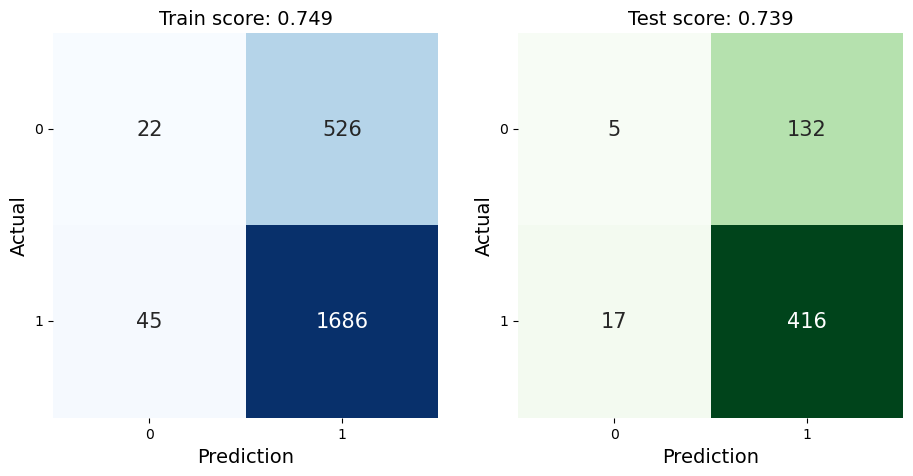

In [17]:
confusion_matrix = plot_confusion_matrix(X_train, y_train, X_test, y_test, pipeline)

# Prediction

In [18]:
X.iloc[0:1]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal
no_urut,,,,,,,,,,,,
1,dewasa,0,0,1,normal,0,1,besar,1,1,3,3


In [19]:
data = ["dewasa", 1, 2, 3, "tinggi", 1, 3, "besar", 1, 2, 1, 2], ["remaja", 0, 3, 2, "normal", 0, 2, "sedang", 1, 0, 2, 1]
X_pred = pd.DataFrame(data, index=["Pak Jarwo", "Neng Tutik"], columns=X.columns)

In [20]:
X_pred['target'] = pipeline.predict(X_pred)
X_pred

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal,target
Pak Jarwo,dewasa,1,2,3,tinggi,1,3,besar,1,2,1,2,1
Neng Tutik,remaja,0,3,2,normal,0,2,sedang,1,0,2,1,1


# Save Model

In [21]:
from jcopml.utils import save_model
import joblib

In [22]:
save_model(pipeline, 'naivebayes_heartdisease.pkl')

Model is pickled as model/naivebayes_heartdisease.pkl


In [23]:
joblib.dump(pipeline, "./model/naivebayes_heartdisease.joblib", compress=True)

['./model/naivebayes_heartdisease.joblib']